In [99]:
# install stuff, set scientific variables to 999 to avoid scientific notation
if (!require("pacman")) install.packages("pacman")
pacman::p_load(WDI, tidyr, car, lmtest, robustbase, MASS, dplyr, knitr, broom)


In [100]:
options(scipen = 999)


In [101]:
# get all of the WDI indicators if indicator file is not already downloaded
indicators <- if (file.exists("indicators.csv")) {
    read.csv("indicators.csv")
} else {
    WDI(indicator = c(
        "SL.EMP.TOTL.SP.ZS",
        "SE.XPD.TOTL.GD.ZS",
        "NY.GDP.PCAP.CD",
        "SM.POP.NETM",
        "SM.POP.TOTL.ZS",
        "SE.TER.CUAT.BA.ZS",
        "SP.POP.TOTL",
        "IP.PAT.RESD"
    ), country = "all") %>%
        write.csv("indicators.csv")
}
# rename the columns
wdi_indicators <- rename(
    indicators,
    c(
        "Country Code" = "iso3c",
        "Total Employment" = "SL.EMP.TOTL.SP.ZS",
        "Education Expenditure % of GDP" = "SE.XPD.TOTL.GD.ZS",
        "GDP per capita" = "NY.GDP.PCAP.CD",
        "Net Migration" = "SM.POP.NETM",
        "PCT Tertiary Education" = "SE.TER.CUAT.BA.ZS",
        "Total Population" = "SP.POP.TOTL",
        "PatentsByResidents" = "IP.PAT.RESD",
        "Total Migrant Population" = "SM.POP.TOTL.ZS"
    )
)


In [102]:
gii <- read.csv("./gii_analysis/gii_2013_2020.csv")
# filter out the rows where the indicator is "Global Innovation Index" and the subindicator type is "Score"
gii_score <- gii %>%
    filter(
        Indicator == "Global Innovation Index",
        Subindicator.Type == "Score (0-100)"
    )
gii_score <- gii_score %>%
    gather(year, value, X2013:X2020) %>%
    select(-Indicator, -Indicator.Id, -Country.Name) %>%
    spread(Subindicator.Type, value)
gii_score <- rename(gii_score, c("Score" = "Score (0-100)"))

# filter out the rows where the indicator is "Global Innovation Index" and the subindicator type is "Rank"
gii_rank <- gii %>%
    filter(Indicator == "Global Innovation Index", Subindicator.Type == "Rank")
gii_rank <- gii_rank %>%
    gather(year, value, X2013:X2020) %>%
    select(-Indicator, -Country.Name, -Indicator.Id) %>%
    spread(Subindicator.Type, value)

# merge into one dataframe
gii_rank_score <- merge(gii_score, gii_rank, by = c("Country.ISO3", "year"))
# remove the X from the year column and convert to integer
gii_rank_score$year <- as.integer(gsub("X", "", gii_rank_score$year))


In [103]:
# merge gii_rank_score with wdi_indicators
gii_wdi <- gii_rank_score %>% right_join(wdi_indicators, by = c("Country.ISO3" = "Country Code", "year" = "year"))
# rename the columns
gii_wdi <- gii_wdi %>%
    rename(c(
        "CountryCode" = "Country.ISO3", "Year" = "year", "Edu" = "PCT Tertiary Education",
        "Mig" = "Net Migration", "EduExp" = "Education Expenditure % of GDP", "TotEmp" = "Total Employment",
        "TotPop" = "Total Population", "Pat" = "PatentsByResidents", "GdpPerCap" = "GDP per capita", "MigPop" = "Total Migrant Population"
    )) %>%
    select("Year", "CountryCode", "Score", "Rank", "Edu", "Mig", "EduExp", "TotEmp", "TotPop", "Pat", "GdpPerCap", "MigPop") %>%
    arrange(CountryCode, Year) %>%
    filter(!(CountryCode == ""))

# write out gii_wdi to csv if it doesn't already exist
if (!file.exists("./gii_analysis/gii_wdi.csv")) write.csv(gii_wdi, "./gii_analysis/gii_wdi.csv")

# lag everything.
gii_wdi <- gii_wdi %>%
    group_by(CountryCode) %>%
    mutate(lag.Mig01 = lag(Mig, n = 1, default = NA)) %>%
    mutate(lag.Mig05 = lag(Mig, n = 5, default = NA)) %>%
    mutate(lag.Mig10 = lag(Mig, n = 10, default = NA)) %>%
    mutate(lag.Mig20 = lag(Mig, n = 20, default = NA)) %>%
    mutate(lag.Edu01 = lag(Edu, n = 1, default = NA)) %>%
    mutate(lag.Edu05 = lag(Edu, n = 5, default = NA)) %>%
    mutate(lag.Edu10 = lag(Edu, n = 10, default = NA)) %>%
    mutate(lag.Edu20 = lag(Edu, n = 20, default = NA)) %>%
    mutate(lag.EduExp01 = lag(EduExp, n = 1, default = NA)) %>%
    mutate(lag.EduExp05 = lag(EduExp, n = 5, default = NA)) %>%
    mutate(lag.EduExp10 = lag(EduExp, n = 10, default = NA)) %>%
    mutate(lag.EduExp20 = lag(EduExp, n = 20, default = NA)) %>%
    mutate(lag.TotEmp01 = lag(TotEmp, n = 1, default = NA)) %>%
    mutate(lag.TotEmp05 = lag(TotEmp, n = 5, default = NA)) %>%
    mutate(lag.TotEmp10 = lag(TotEmp, n = 10, default = NA)) %>%
    mutate(lag.TotEmp20 = lag(TotEmp, n = 20, default = NA)) %>%
    mutate(lag.TotPop01 = lag(TotPop, n = 1, default = NA)) %>%
    mutate(lag.TotPop05 = lag(TotPop, n = 5, default = NA)) %>%
    mutate(lag.TotPop10 = lag(TotPop, n = 10, default = NA)) %>%
    mutate(lag.TotPop20 = lag(TotPop, n = 20, default = NA)) %>%
    mutate(lag.MigPop01 = lag(MigPop, n = 1, default = NA)) %>%
    mutate(lag.MigPop05 = lag(MigPop, n = 5, default = NA)) %>%
    mutate(lag.MigPop10 = lag(MigPop, n = 10, default = NA)) %>%
    mutate(lag.MigPop20 = lag(MigPop, n = 20, default = NA))

head(gii_wdi)

# write out gii_wdi_lagged to csv if it doesn't already exist
if (!file.exists("./gii_analysis/gii_wdi_lagged.csv")) write.csv(gii_wdi, "./gii_analysis/gii_wdi_lagged.csv")


Year,CountryCode,Score,Rank,Edu,Mig,EduExp,TotEmp,TotPop,Pat,⋯,lag.TotEmp10,lag.TotEmp20,lag.TotPop01,lag.TotPop05,lag.TotPop10,lag.TotPop20,lag.MigPop01,lag.MigPop05,lag.MigPop10,lag.MigPop20
<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1960,ABW,NA,NA,NA,0,NA,NA,54608,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1961,ABW,NA,NA,NA,-569,NA,NA,55811,NA,⋯,NA,NA,54608,NA,NA,NA,NA,NA,NA,NA
1962,ABW,NA,NA,NA,-609,NA,NA,56682,NA,⋯,NA,NA,55811,NA,NA,NA,NA,NA,NA,NA
1963,ABW,NA,NA,NA,-646,NA,NA,57475,NA,⋯,NA,NA,56682,NA,NA,NA,NA,NA,NA,NA
1964,ABW,NA,NA,NA,-684,NA,NA,58178,NA,⋯,NA,NA,57475,NA,NA,NA,NA,NA,NA,NA
1965,ABW,NA,NA,NA,-726,NA,NA,58782,NA,⋯,NA,NA,58178,54608,NA,NA,NA,NA,NA,NA


In [104]:
lag1_Edu_EduExp_Mig_TotEmp <- lm(Score ~ lag.Mig01 + lag.Edu01 + lag.TotEmp01 + lag.EduExp01, data = gii_wdi)
vif(lag1_Edu_EduExp_Mig_TotEmp)
bptest(lag1_Edu_EduExp_Mig_TotEmp)
nobs(lag1_Edu_EduExp_Mig_TotEmp)
summary(lag1_Edu_EduExp_Mig_TotEmp)


lag.Mig01    lag.Edu01 lag.TotEmp01 lag.EduExp01 
    1.113866     1.142025     1.031452     1.109359


	studentized Breusch-Pagan test

data:  lag1_Edu_EduExp_Mig_TotEmp
BP = 28.022, df = 4, p-value = 0.00001235


[1] 295


Call:
lm(formula = Score ~ lag.Mig01 + lag.Edu01 + lag.TotEmp01 + lag.EduExp01, 
    data = gii_wdi)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.7847  -4.5632  -0.4765   4.7445  16.8776 

Coefficients:
                 Estimate   Std. Error t value             Pr(>|t|)    
(Intercept)  15.720203211  3.718067939   4.228      0.0000316277907 ***
lag.Mig01     0.000010033  0.000002493   4.024      0.0000730077466 ***
lag.Edu01     0.737718344  0.053679220  13.743 < 0.0000000000000002 ***
lag.TotEmp01  0.006030726  0.053767322   0.112                0.911    
lag.EduExp01  2.205661764  0.316007218   6.980      0.0000000000202 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.733 on 290 degrees of freedom
  (15887 observations deleted due to missingness)
Multiple R-squared:  0.5732,	Adjusted R-squared:  0.5673 
F-statistic: 97.37 on 4 and 290 DF,  p-value: < 0.00000000000000022


In [105]:
lag5_Edu_EduExp_Mig_TotEmp <- rlm(Score ~ lag.Mig05 + lag.Edu05 + lag.TotEmp05 + lag.EduExp05, data = gii_wdi)
vif(lag5_Edu_EduExp_Mig_TotEmp)
bptest(lag5_Edu_EduExp_Mig_TotEmp)
nobs(lag5_Edu_EduExp_Mig_TotEmp)
summary(lag5_Edu_EduExp_Mig_TotEmp)


lag.Mig05    lag.Edu05 lag.TotEmp05 lag.EduExp05 
    1.152333     1.175769     1.071233     1.114892


	studentized Breusch-Pagan test

data:  lag5_Edu_EduExp_Mig_TotEmp
BP = 23.354, df = 4, p-value = 0.0001076


[1] 194


Call: rlm(formula = Score ~ lag.Mig05 + lag.Edu05 + lag.TotEmp05 + 
    lag.EduExp05, data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-35.3889  -4.2797  -0.5315   4.5481  22.7253 

Coefficients:
             Value   Std. Error t value
(Intercept)  16.9926  4.4090     3.8541
lag.Mig05     0.0000  0.0000     2.2148
lag.Edu05     0.8208  0.0691    11.8766
lag.TotEmp05  0.0198  0.0612     0.3243
lag.EduExp05  1.4514  0.3934     3.6893

Residual standard error: 6.425 on 189 degrees of freedom
  (15988 observations deleted due to missingness)

In [106]:
model4 <- rlm(Score ~ Mig + Edu + Mig:Edu, data = gii_wdi)
nobs(model4)
summary(model4)


[1] 326


Call: rlm(formula = Score ~ Mig + Edu + Mig:Edu, data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-23.8235  -5.4397  -0.9012   5.3733  18.9278 

Coefficients:
            Value   Std. Error t value
(Intercept) 24.4477  1.0757    22.7264
Mig          0.0000  0.0000     2.6535
Edu          0.8141  0.0513    15.8816
Mig:Edu      0.0000  0.0000    -1.0156

Residual standard error: 8.093 on 322 degrees of freedom
  (15856 observations deleted due to missingness)

In [107]:
model5 <- lm(Score ~ Mig + EduExp + Mig:EduExp, data = gii_wdi)
nobs(model5)
summary(model5)


[1] 945


Call:
lm(formula = Score ~ Mig + EduExp + Mig:EduExp, data = gii_wdi)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.808  -8.308  -1.933   7.548  30.754 

Coefficients:
                Estimate   Std. Error t value             Pr(>|t|)    
(Intercept) 28.387074178  1.108628924  25.606 < 0.0000000000000002 ***
Mig         -0.000007655  0.000004502  -1.700               0.0894 .  
EduExp       1.743836346  0.227923417   7.651   0.0000000000000493 ***
Mig:EduExp   0.000005487  0.000001115   4.922   0.0000010103192624 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.86 on 941 degrees of freedom
  (15237 observations deleted due to missingness)
Multiple R-squared:  0.1536,	Adjusted R-squared:  0.1509 
F-statistic: 56.93 on 3 and 941 DF,  p-value: < 0.00000000000000022


In [108]:
lag1_Edu_EduExp_Mig <- rlm(Score ~ lag.Edu01 + lag.EduExp01 + lag.Mig01, data = gii_wdi)
vif(lag1_Edu_EduExp_Mig)
bptest(lag1_Edu_EduExp_Mig)
nobs(lag1_Edu_EduExp_Mig)
summary(lag1_Edu_EduExp_Mig)


lag.Edu01 lag.EduExp01    lag.Mig01 
    1.141320     1.085046     1.101725


	studentized Breusch-Pagan test

data:  lag1_Edu_EduExp_Mig
BP = 23.415, df = 3, p-value = 0.00003309


[1] 295


Call: rlm(formula = Score ~ lag.Edu01 + lag.EduExp01 + lag.Mig01, data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-29.7083  -4.6105  -0.2159   4.8590  17.4731 

Coefficients:
             Value   Std. Error t value
(Intercept)  14.6122  1.6620     8.7920
lag.Edu01     0.7365  0.0547    13.4562
lag.EduExp01  2.5271  0.3188     7.9276
lag.Mig01     0.0000  0.0000     3.7332

Residual standard error: 7.125 on 291 degrees of freedom
  (15887 observations deleted due to missingness)

In [109]:
lag5_Edu_EduExp_Mig <- rlm(Score ~ lag.Edu05 + lag.EduExp05 + lag.Mig05, data = gii_wdi)
vif(lag5_Edu_EduExp_Mig)
Anova(lag5_Edu_EduExp_Mig)
bptest(lag5_Edu_EduExp_Mig)
nobs(lag5_Edu_EduExp_Mig)
summary(lag5_Edu_EduExp_Mig)


lag.Edu05 lag.EduExp05    lag.Mig05 
    1.169111     1.072749     1.117787

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
lag.Edu05,1,144.431912,0.00000000000000000000000041091
lag.EduExp05,1,13.897730,0.00025460574333630687452606489
lag.Mig05,1,5.479273,0.02028045142163338587781851174
Residuals,190,NA,NA



	studentized Breusch-Pagan test

data:  lag5_Edu_EduExp_Mig
BP = 18.497, df = 3, p-value = 0.0003473


[1] 194


Call: rlm(formula = Score ~ lag.Edu05 + lag.EduExp05 + lag.Mig05, data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-35.3926  -4.3078  -0.4573   4.5188  22.9523 

Coefficients:
             Value   Std. Error t value
(Intercept)  18.2791  1.9697     9.2802
lag.Edu05     0.8193  0.0682    12.0180
lag.EduExp05  1.4231  0.3817     3.7280
lag.Mig05     0.0000  0.0000     2.3408

Residual standard error: 6.508 on 190 degrees of freedom
  (15988 observations deleted due to missingness)

There is a ton of heteroskedasticity so we have to log the dependent variable in an atttempt to defeat such


In [110]:
# # log score
# log_lag5_Edu_EduExp_Mig <- rlm(log(Pat) ~ Pat + Mig, data = gii_wdi)
# nobs(log_lag5_Edu_EduExp_Mig)
# Anova(log_lag5_Edu_EduExp_Mig)
# car::vif(log_lag5_Edu_EduExp_Mig)
# lmtest::bptest(log_lag5_Edu_EduExp_Mig)
# summary(log_lag5_Edu_EduExp_Mig)
# coeftest(log_lag5_Edu_EduExp_Mig)
# plot(log_lag5_Edu_EduExp_Mig)
pat_lagMig <- rlm(log(Score) ~ Edu + lag.Mig20, data = gii_wdi)
nobs(pat_lagMig)
vif(pat_lagMig)
Anova(pat_lagMig)
coeftest(pat_lagMig)


[1] 326

Edu lag.Mig20 
 1.083341  1.083341

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
Edu,1,263.36448,0.00000000000000000000000000000000000000000009915511
lag.Mig20,1,11.71544,0.00069962795298987405512303183741096290759742259979
Residuals,323,NA,NA



z test of coefficients:

                  Estimate     Std. Error  z value              Pr(>|z|)    
(Intercept) 3.253464096559 0.028208502917 115.3363 < 0.00000000000000022 ***
Edu         0.021562451467 0.001328677355  16.2285 < 0.00000000000000022 ***
lag.Mig20   0.000000146900 0.000000042918   3.4228             0.0006198 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 1036


Call: rlm(formula = log(Score) ~ lag.Mig05, data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-1.58815 -0.20925 -0.02153  0.21171  0.65829 

Coefficients:
            Value    Std. Error t value 
(Intercept)   3.5392   0.0102   347.2673
lag.Mig05     0.0000   0.0000     9.7251

Residual standard error: 0.3112 on 1034 degrees of freedom
  (15146 observations deleted due to missingness)

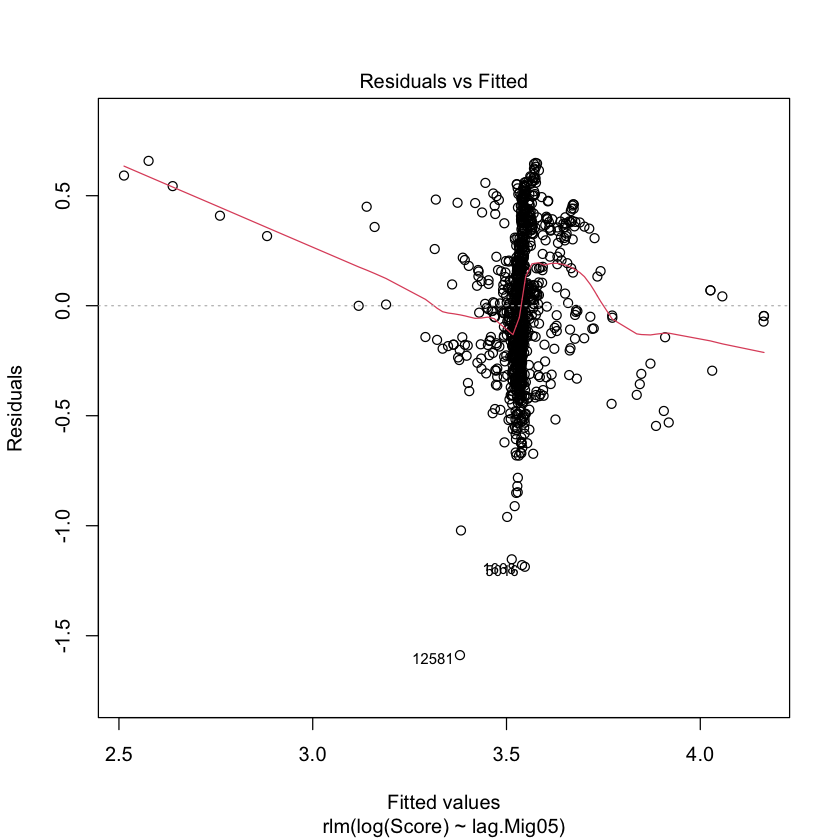

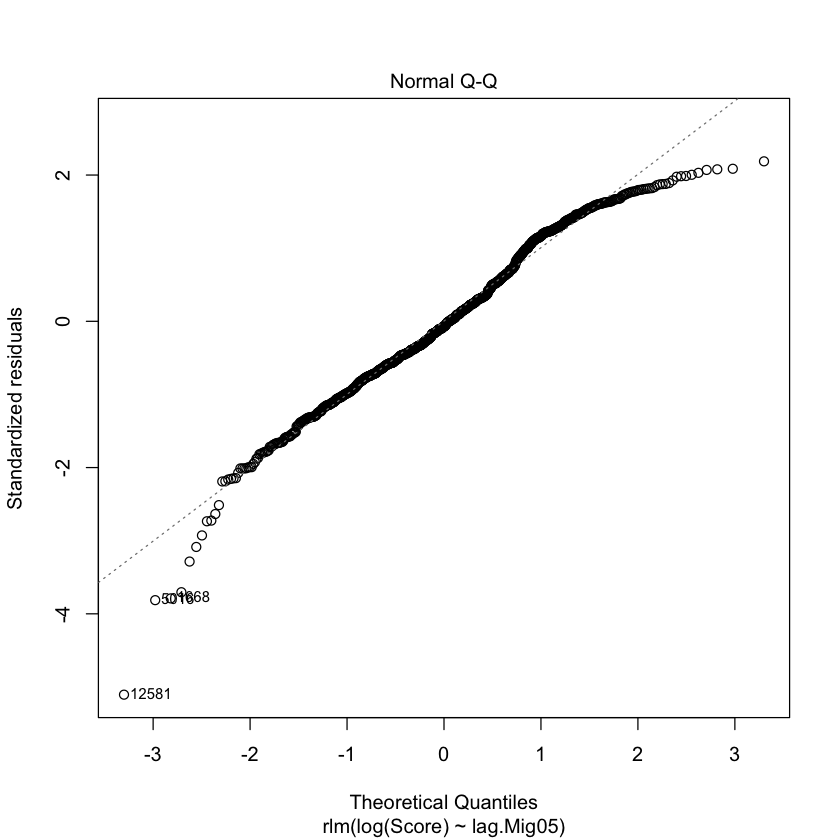

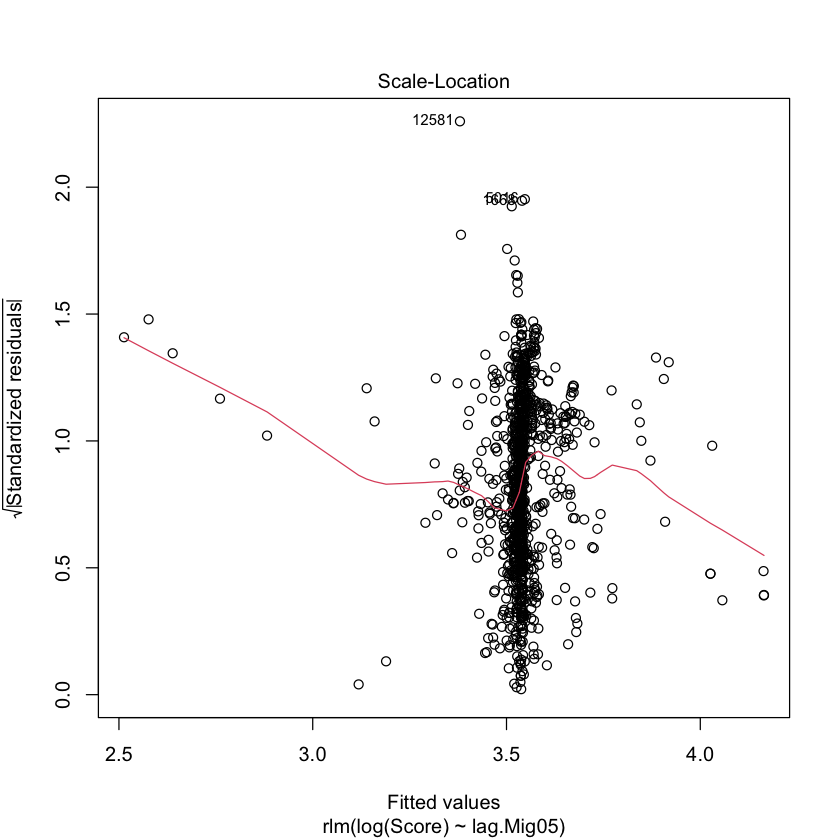

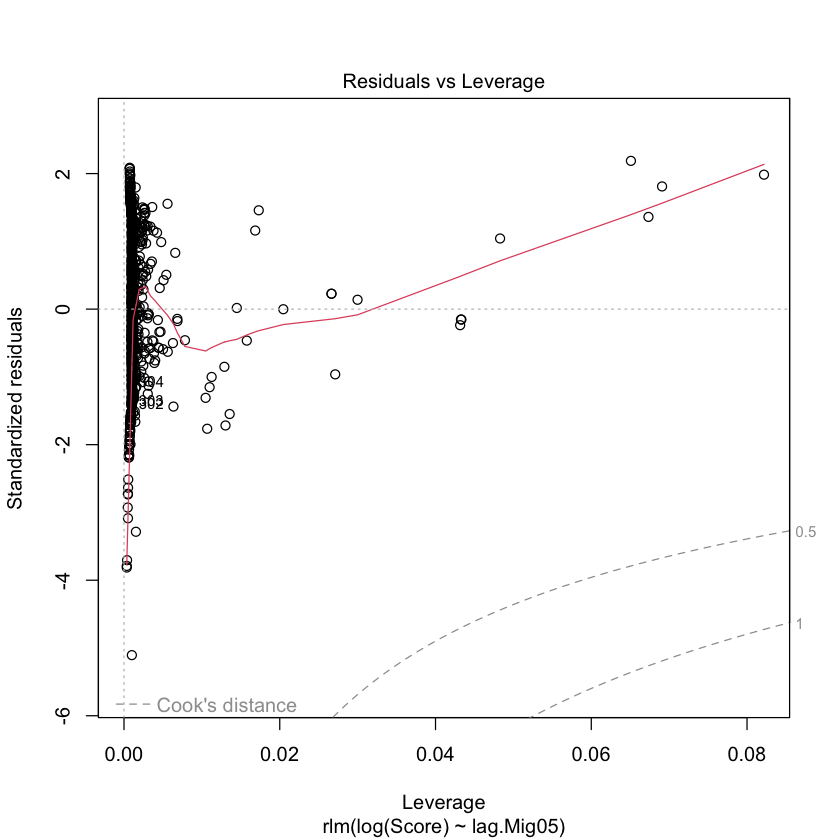

In [111]:
rl <- rlm(log(Score) ~ lag.Mig05, data = gii_wdi)
nobs(rl)
summary(rl)
plot(rl)


Warning message in log(lag.Mig05):
“NaNs produced”


[1] 172

log(Edu)    log(EduExp) log(lag.Mig05)    log(TotEmp)    log(TotPop) 
      1.113463       1.156319       1.902930       1.356420       1.823221

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log(Edu),1,120.7882431,0.000000000000000000001848827
log(EduExp),1,25.8978526,0.000000966154129799688360004
log(lag.Mig05),1,20.2608308,0.000012669510039792481576829
log(TotEmp),1,0.4813491,0.488781594513344797015008680
log(TotPop),1,3.0258827,0.083799295093312575755106764
Residuals,166,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_score_Mig05
BP = 2.7898, df = 5, p-value = 0.7324



Call: rlm(formula = log(Score) ~ log(Edu) + log(EduExp) + log(lag.Mig05) + 
    log(TotEmp) + log(TotPop), data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-0.62629 -0.10895  0.02434  0.11658  0.26723 

Coefficients:
               Value   Std. Error t value
(Intercept)     2.9229  0.5190     5.6314
log(Edu)        0.2532  0.0230    10.9904
log(EduExp)     0.2135  0.0419     5.0890
log(lag.Mig05)  0.0421  0.0094     4.5012
log(TotEmp)    -0.0716  0.1032    -0.6938
log(TotPop)    -0.0201  0.0116    -1.7395

Residual standard error: 0.1691 on 166 degrees of freedom
  (16010 observations deleted due to missingness)


z test of coefficients:

                 Estimate Std. Error z value              Pr(>|z|)    
(Intercept)     2.9228886  0.5190316  5.6314         0.00000001787 ***
log(Edu)        0.2531685  0.0230355 10.9904 < 0.00000000000000022 ***
log(EduExp)     0.2134526  0.0419440  5.0890         0.00000035997 ***
log(lag.Mig05)  0.0421024  0.0093536  4.5012         0.00000675698 ***
log(TotEmp)    -0.0715674  0.1031538 -0.6938               0.48781    
log(TotPop)    -0.0201290  0.0115717 -1.7395               0.08195 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


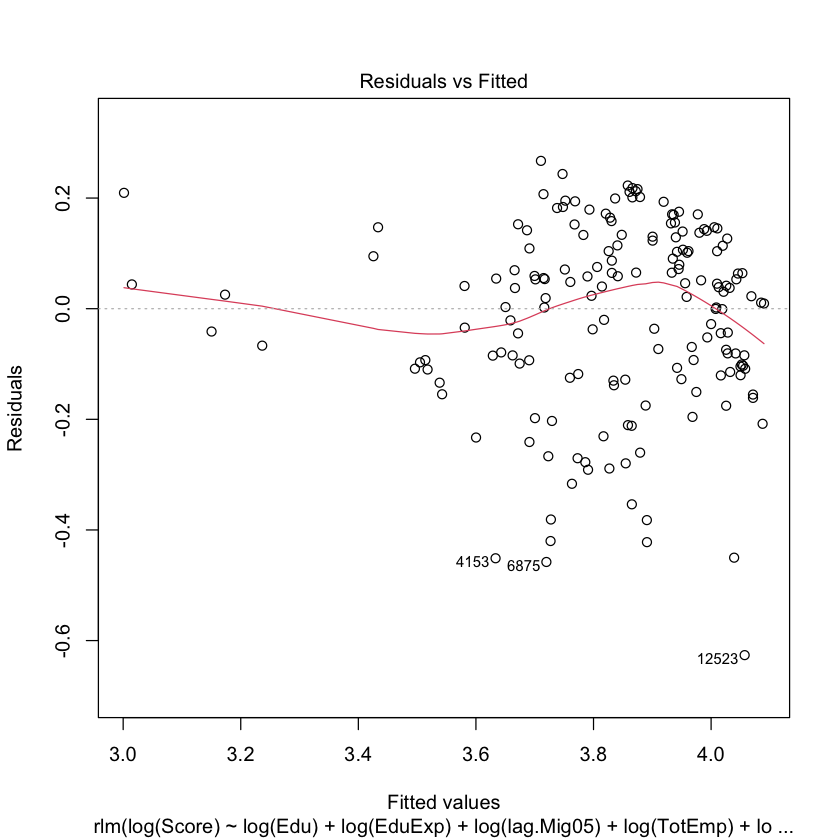

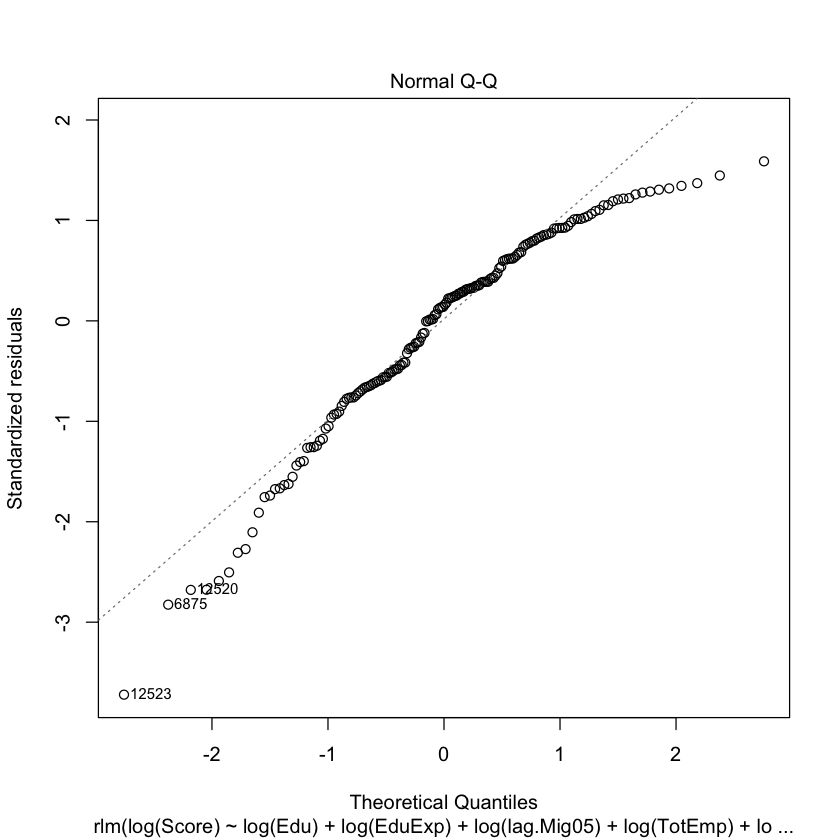

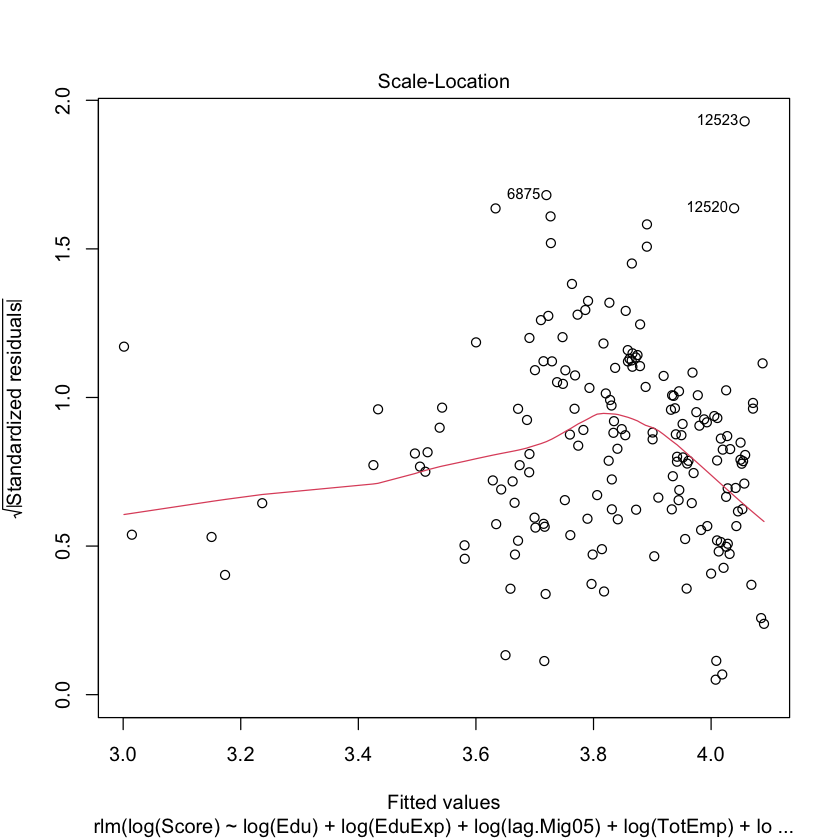

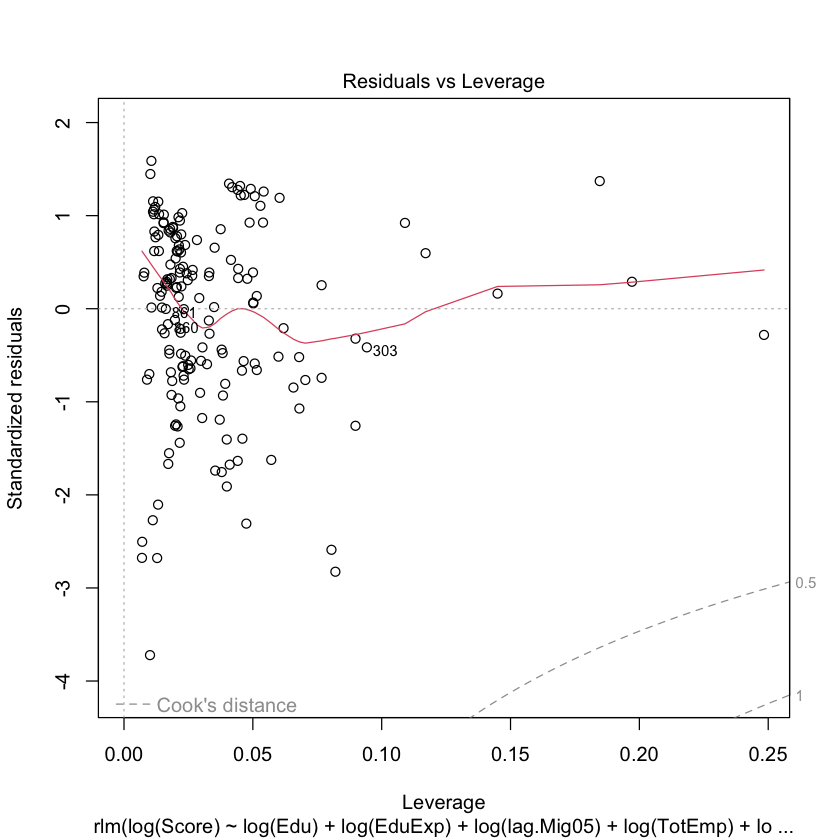

In [112]:
log_everything_score_Mig05 <- rlm(log(Score) ~ log(Edu) + log(EduExp) + log(lag.Mig05) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_score_Mig05)
vif(log_everything_score_Mig05)
Anova(log_everything_score_Mig05)
bptest(log_everything_score_Mig05)
summary(log_everything_score_Mig05)
coeftest(log_everything_score_Mig05)
plot(log_everything_score_Mig05)


Warning message in log(lag.Mig01):
“NaNs produced”


[1] 26

log(Edu)    log(MigPop)    log(EduExp) log(lag.Mig01)    log(TotEmp) 
      1.721598       1.958587       1.169101       2.800552       1.374968 
   log(TotPop) 
      2.448620

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log(Edu),1,5.7193016839,0.02728252
log(MigPop),1,0.1252091881,0.72734827
log(EduExp),1,0.4651333118,0.50346462
log(lag.Mig01),1,7.8948544710,0.01118280
log(TotEmp),1,0.0002571256,0.98737355
log(TotPop),1,2.1221405335,0.16151194
Residuals,19,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_score_Mig01
BP = 11.325, df = 6, p-value = 0.07884



Call: rlm(formula = log(Score) ~ log(Edu) + log(MigPop) + log(EduExp) + 
    log(lag.Mig01) + log(TotEmp) + log(TotPop), data = gii_wdi)
Residuals:
     Min       1Q   Median       3Q      Max 
-0.19478 -0.06645 -0.01436  0.08667  0.23452 

Coefficients:
               Value   Std. Error t value
(Intercept)     2.9433  1.4061     2.0932
log(Edu)        0.2498  0.1045     2.3915
log(MigPop)     0.0195  0.0551     0.3538
log(EduExp)     0.0964  0.1414     0.6820
log(lag.Mig01)  0.0834  0.0297     2.8098
log(TotEmp)     0.0055  0.3401     0.0160
log(TotPop)    -0.0554  0.0380    -1.4568

Residual standard error: 0.1102 on 19 degrees of freedom
  (16156 observations deleted due to missingness)


z test of coefficients:

                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)     2.9432966  1.4061168  2.0932 0.036330 * 
log(Edu)        0.2498098  0.1044571  2.3915 0.016779 * 
log(MigPop)     0.0194989  0.0551051  0.3538 0.723452   
log(EduExp)     0.0964022  0.1413507  0.6820 0.495235   
log(lag.Mig01)  0.0834206  0.0296894  2.8098 0.004958 **
log(TotEmp)     0.0054541  0.3401331  0.0160 0.987206   
log(TotPop)    -0.0553563  0.0379997 -1.4568 0.145184   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


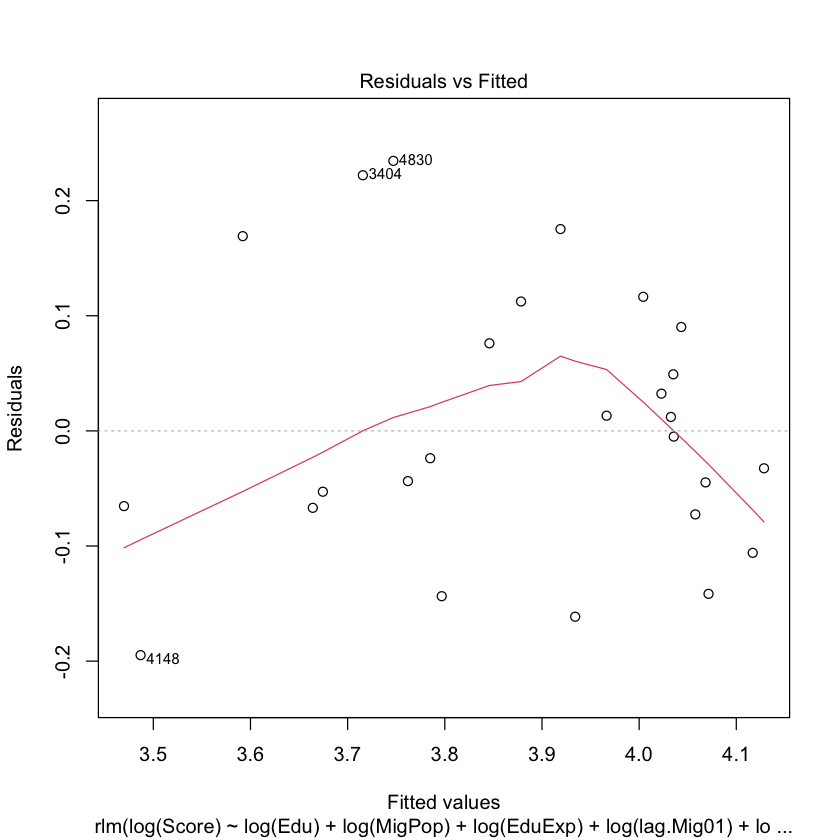

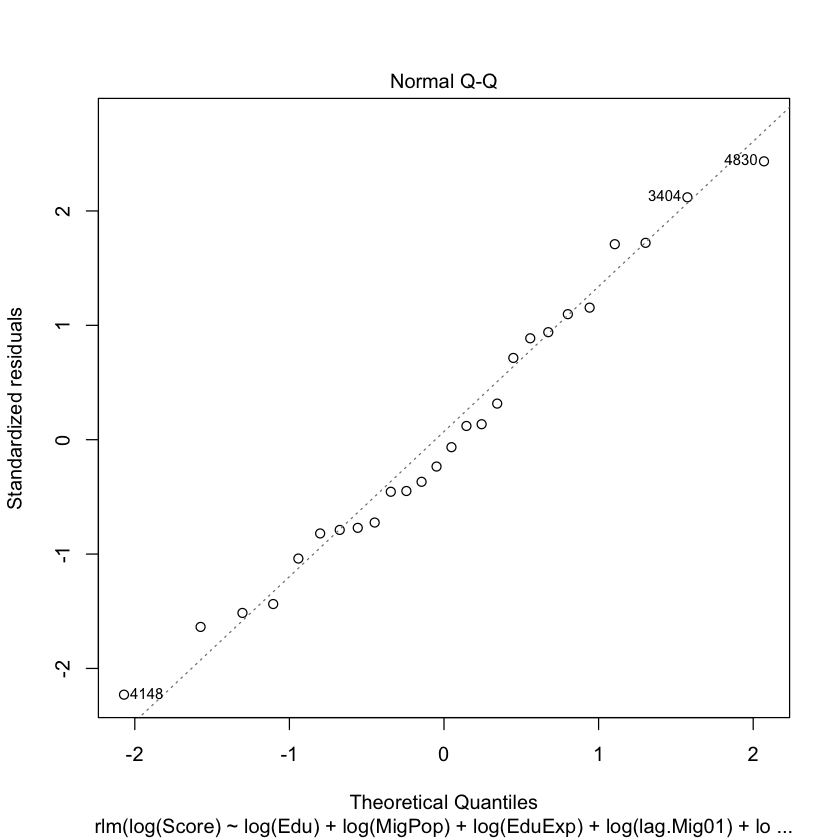

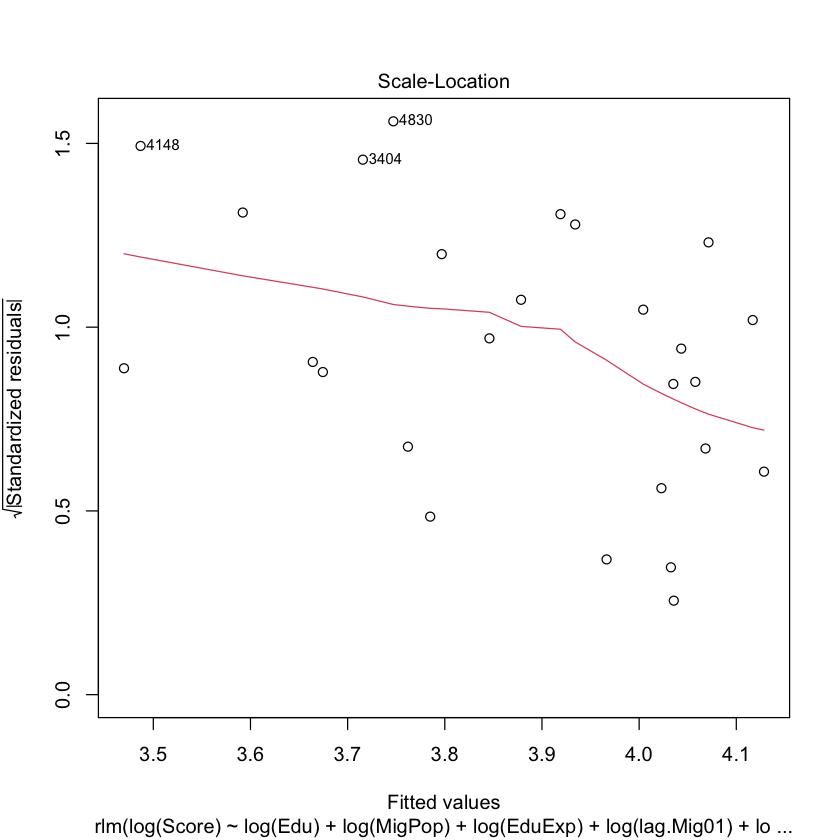

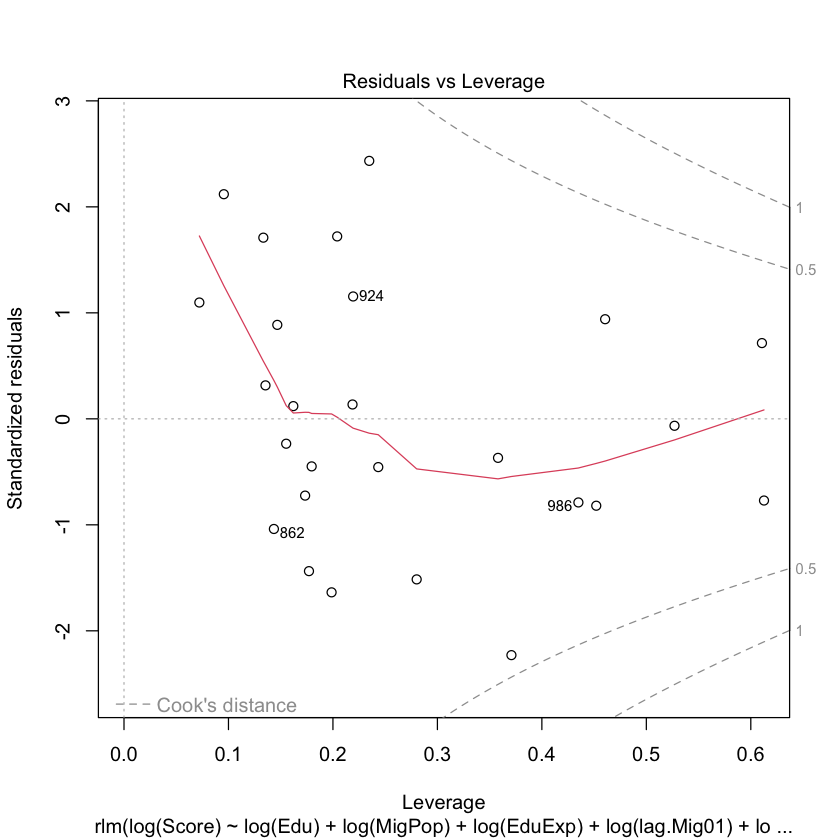

In [113]:
log_everything_score_Mig01 <- rlm(log(Score) ~ log(Edu) + log(MigPop) + log(EduExp) + log(lag.Mig01) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_score_Mig01)
vif(log_everything_score_Mig01)
Anova(log_everything_score_Mig01)
bptest(log_everything_score_Mig01)
summary(log_everything_score_Mig01)
coeftest(log_everything_score_Mig01)
plot(log_everything_score_Mig01)


Warning message in log1p(lag.Mig10):
“NaNs produced”


[1] 175

log1p(Edu)      log(EduExp) log1p(lag.Mig10)      log(TotEmp) 
        1.124472         1.116575         2.051425         1.314509 
     log(TotPop) 
        1.943966

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log1p(Edu),1,139.8326235,0.000000000000000000000006779731
log(EduExp),1,72.4593506,0.000000000000008894036324252709
log1p(lag.Mig10),1,1.7471603,0.188020551617779863029511489003
log(TotEmp),1,1.5214066,0.219119523244670655337529296958
log(TotPop),1,0.4557023,0.500561885685348428864926972892
Residuals,169,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_score_Mig10
BP = 1.5139, df = 5, p-value = 0.9115



Call: rlm(formula = log(Score) ~ log1p(Edu) + log(EduExp) + log1p(lag.Mig10) + 
    log(TotEmp) + log(TotPop), data = gii_wdi)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.705966 -0.100324  0.005201  0.110065  0.416605 

Coefficients:
                 Value   Std. Error t value
(Intercept)       1.7691  0.4692     3.7703
log1p(Edu)        0.2846  0.0241    11.8251
log(EduExp)       0.3112  0.0366     8.5123
log1p(lag.Mig10)  0.0119  0.0090     1.3218
log(TotEmp)       0.1116  0.0904     1.2335
log(TotPop)       0.0084  0.0124     0.6751

Residual standard error: 0.162 on 169 degrees of freedom
  (16007 observations deleted due to missingness)


z test of coefficients:

                  Estimate Std. Error z value              Pr(>|z|)    
(Intercept)      1.7691213  0.4692289  3.7703             0.0001631 ***
log1p(Edu)       0.2846478  0.0240715 11.8251 < 0.00000000000000022 ***
log(EduExp)      0.3111882  0.0365575  8.5123 < 0.00000000000000022 ***
log1p(lag.Mig10) 0.0118845  0.0089911  1.3218             0.1862341    
log(TotEmp)      0.1115520  0.0904388  1.2335             0.2174068    
log(TotPop)      0.0083750  0.0124064  0.6751             0.4996394    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


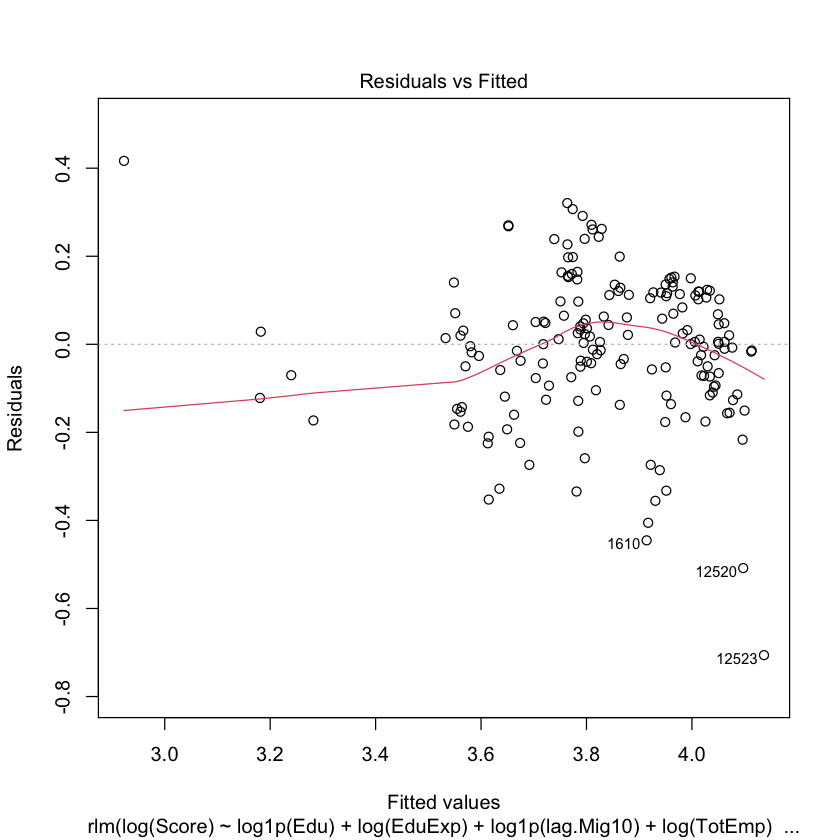

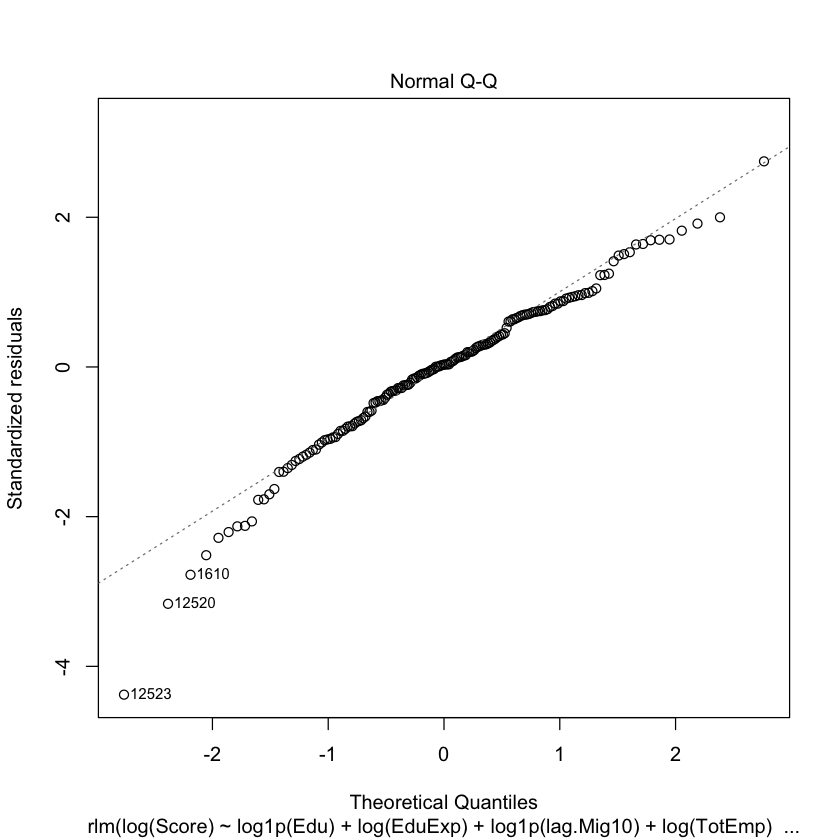

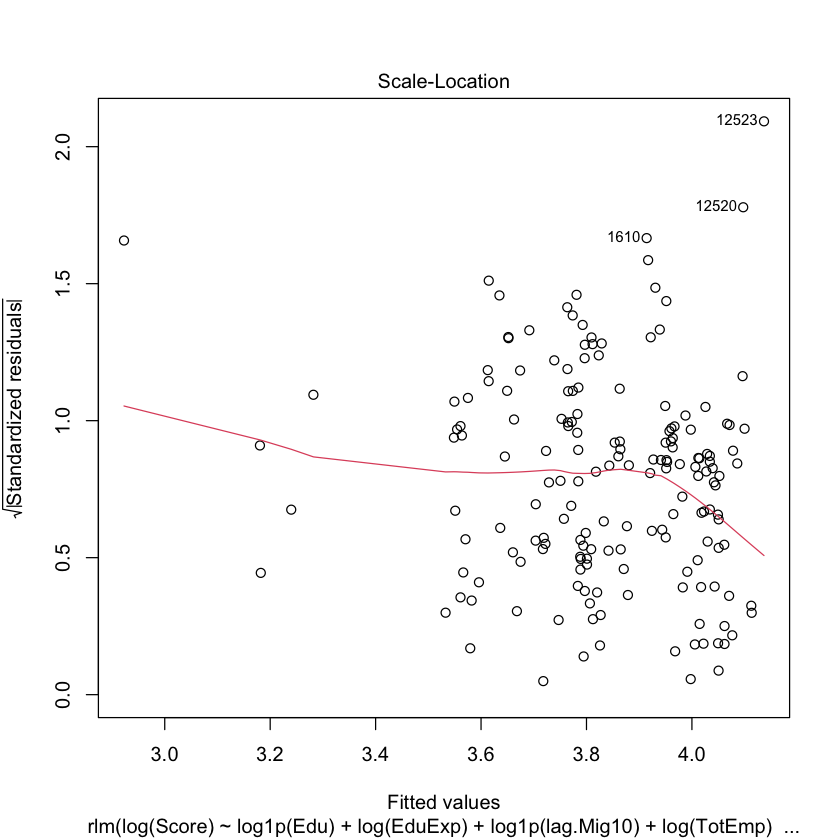

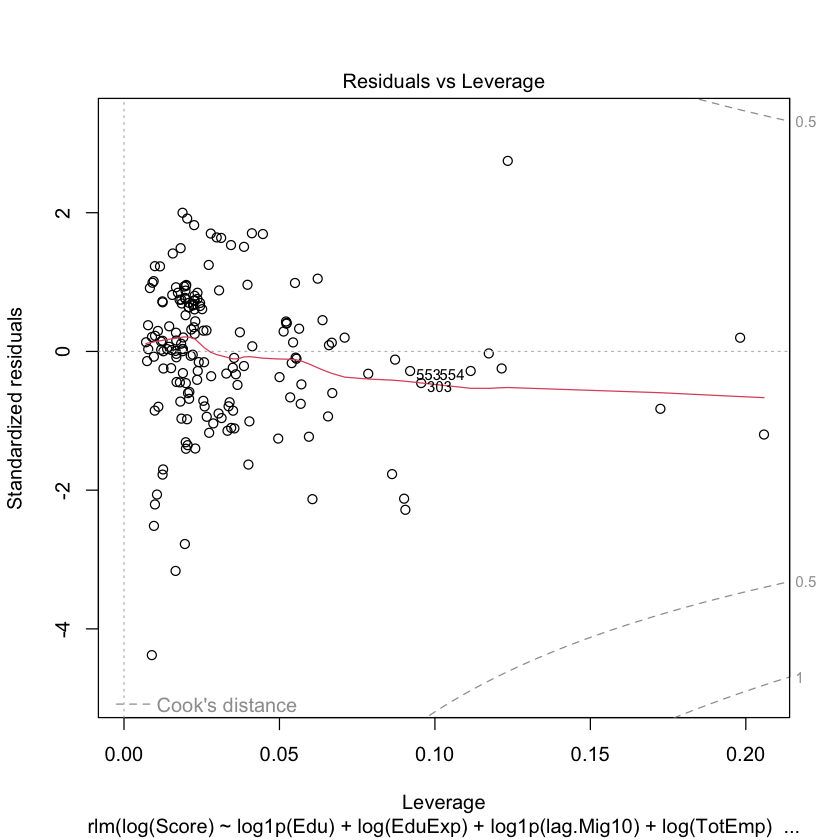

In [114]:
log_everything_score_Mig10 <- rlm(log(Score) ~ log1p(Edu) + log(EduExp) + log1p(lag.Mig10) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_score_Mig10)
vif(log_everything_score_Mig10)
Anova(log_everything_score_Mig10)
bptest(log_everything_score_Mig10)
summary(log_everything_score_Mig10)
coeftest(log_everything_score_Mig10)
plot(log_everything_score_Mig10)

Warning message in log1p(lag.Mig10):
“NaNs produced”
Warning message in rlm.default(x, y, weights, method = method, wt.method = wt.method, :
“'rlm' failed to converge in 20 steps”


[1] 26

log1p(Edu)      log(EduExp)      log(MigPop) log1p(lag.Mig10) 
        1.273222         1.139709         1.613571         4.104385 
     log(TotEmp)      log(TotPop) 
        2.063884         3.431373

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log1p(Edu),1,5.9639809036,0.02455007
log(EduExp),1,2.6150522146,0.12233616
log(MigPop),1,0.4428342897,0.51375568
log1p(lag.Mig10),1,0.0001741124,0.98960966
log(TotEmp),1,0.0741409702,0.78833732
log(TotPop),1,0.3962935375,0.53650669
Residuals,19,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_EduByImmigrant
BP = 10.106, df = 6, p-value = 0.1203



Call: rlm(formula = log(Score) ~ log1p(Edu) + log(EduExp) + log(MigPop) + 
    log1p(lag.Mig10) + log(TotEmp) + log(TotPop), data = gii_wdi)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.291973 -0.071825 -0.002676  0.075462  0.243481 

Coefficients:
                 Value   Std. Error t value
(Intercept)       1.6775  1.8956     0.8850
log1p(Edu)        0.2487  0.1018     2.4421
log(EduExp)       0.2482  0.1535     1.6171
log(MigPop)       0.0378  0.0569     0.6655
log1p(lag.Mig10) -0.0006  0.0438    -0.0132
log(TotEmp)       0.1153  0.4236     0.2723
log(TotPop)       0.0307  0.0487     0.6295

Residual standard error: 0.1121 on 19 degrees of freedom
  (16156 observations deleted due to missingness)


z test of coefficients:

                   Estimate Std. Error z value Pr(>|z|)  
(Intercept)       1.6775161  1.8956040  0.8850   0.3762  
log1p(Edu)        0.2487279  0.1018489  2.4421   0.0146 *
log(EduExp)       0.2481797  0.1534709  1.6171   0.1059  
log(MigPop)       0.0378347  0.0568551  0.6655   0.5058  
log1p(lag.Mig10) -0.0005775  0.0437660 -0.0132   0.9895  
log(TotEmp)       0.1153454  0.4236149  0.2723   0.7854  
log(TotPop)       0.0306817  0.0487383  0.6295   0.5290  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


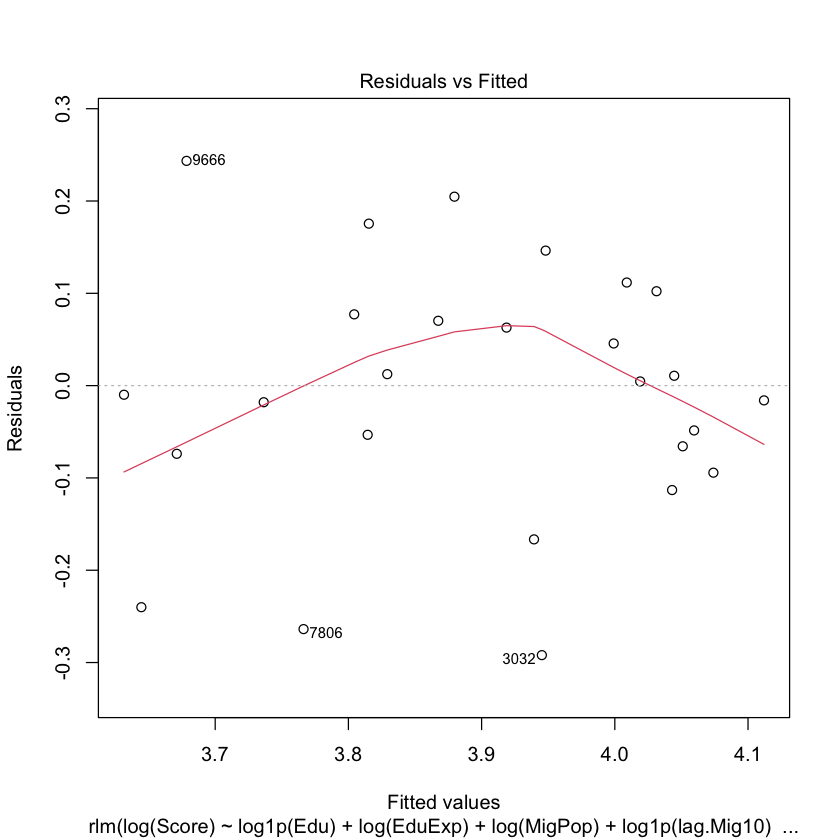

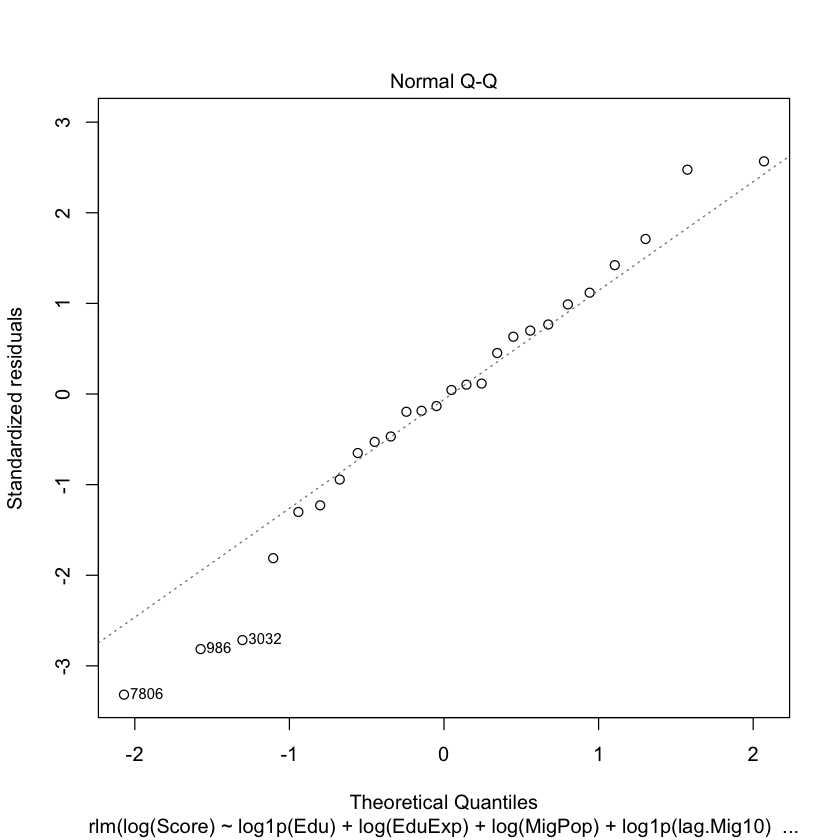

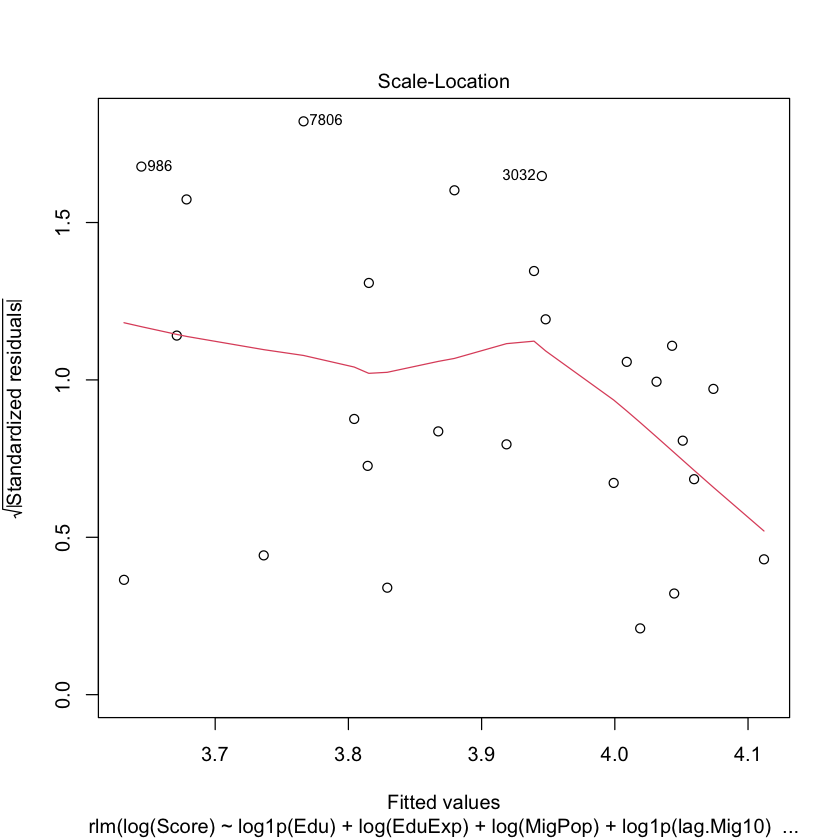

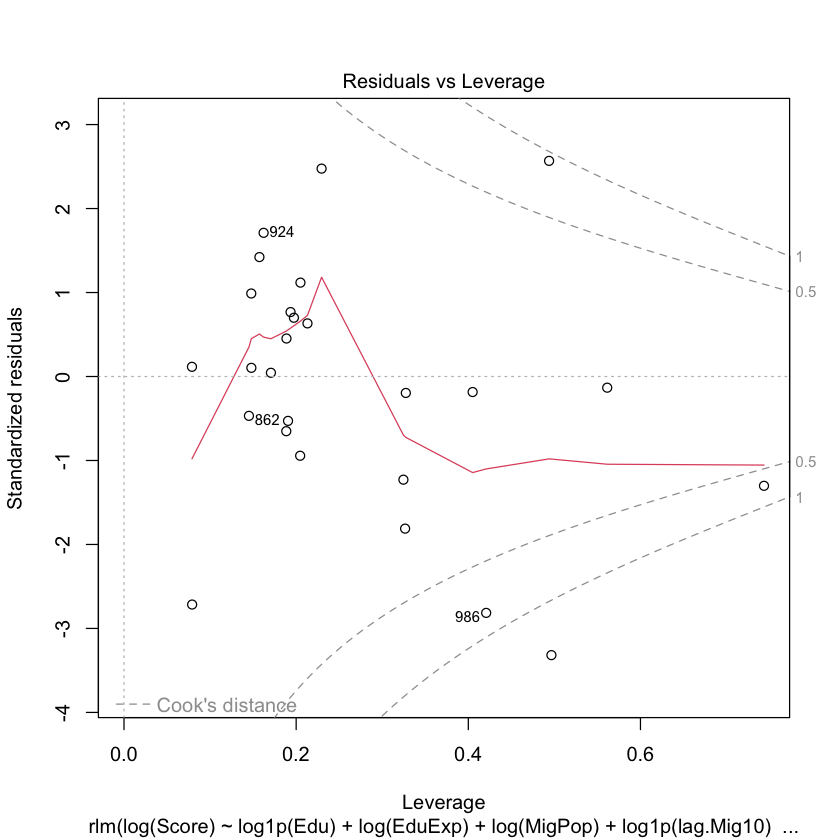

In [120]:
log_everything_EduByImmigrant <- rlm(log(Score) ~ log1p(Edu) +  log(EduExp) + log(MigPop) + log1p(lag.Mig10) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_EduByImmigrant)
vif(log_everything_EduByImmigrant)
Anova(log_everything_EduByImmigrant)
bptest(log_everything_EduByImmigrant)
summary(log_everything_EduByImmigrant)
coeftest(log_everything_EduByImmigrant)
plot(log_everything_EduByImmigrant)


In [133]:
log_everything_EduByImmigrant <- rlm(log(Score) ~  log(Edu) + log(EduExp) + log(lag.Mig01) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_EduByImmigrant)
vif(log_everything_EduByImmigrant)
Anova(log_everything_EduByImmigrant)
bptest(log_everything_EduByImmigrant)
# summary(log_everything_EduByImmigrant)
coeftest(log_everything_EduByImmigrant)
# plot(log_everything_EduByImmigrant)


Warning message in log(lag.Mig01):
“NaNs produced”


[1] 178

log(Edu)    log(EduExp) log(lag.Mig01)    log(TotEmp)    log(TotPop) 
      1.168654       1.203632       1.808850       1.199397       1.772767

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log(Edu),1,83.46001695,0.0000000000000001766604
log(EduExp),1,18.47129065,0.0000288108433659378874
log(lag.Mig01),1,17.48836815,0.0000459725429858645770
log(TotEmp),1,0.04654342,0.8294466282533620171691
log(TotPop),1,4.03937910,0.0460132398722408603176
Residuals,172,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_EduByImmigrant
BP = 1.7119, df = 5, p-value = 0.8874



z test of coefficients:

                Estimate Std. Error z value              Pr(>|z|)    
(Intercept)     2.479082   0.518935  4.7773           0.000001777 ***
log(Edu)        0.290411   0.031789  9.1356 < 0.00000000000000022 ***
log(EduExp)     0.201943   0.046987  4.2978           0.000017248 ***
log(lag.Mig01)  0.043928   0.010504  4.1819           0.000028907 ***
log(TotEmp)     0.022661   0.105037  0.2157               0.82919    
log(TotPop)    -0.024308   0.012094 -2.0098               0.04445 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [132]:
log_everything_EduByImmigrant <- rlm(log(Score) ~  log(Edu) + log(EduExp) + log(lag.Mig05) + log(MigPop) + log(TotEmp) + log(TotPop), data = gii_wdi)
nobs(log_everything_EduByImmigrant)
vif(log_everything_EduByImmigrant)
Anova(log_everything_EduByImmigrant)
bptest(log_everything_EduByImmigrant)
# summary(log_everything_EduByImmigrant)
coeftest(log_everything_EduByImmigrant)
# plot(log_everything_EduByImmigrant)


Warning message in log(lag.Mig05):
“NaNs produced”


[1] 25

log(Edu)    log(EduExp) log(lag.Mig05)    log(MigPop)    log(TotEmp) 
      1.227485       1.262569       3.826883       2.377123       1.673015 
   log(TotPop) 
      3.582063

,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>
log(Edu),1,8.548986527,0.009065458
log(EduExp),1,0.974289454,0.336696093
log(lag.Mig05),1,2.316534774,0.145378882
log(MigPop),1,0.004517959,0.947150928
log(TotEmp),1,0.039154108,0.845361153
log(TotPop),1,0.551254177,0.467384993
Residuals,18,NA,NA



	studentized Breusch-Pagan test

data:  log_everything_EduByImmigrant
BP = 9.8556, df = 6, p-value = 0.1309



z test of coefficients:

                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)     3.0626986  1.7293086  1.7711 0.076552 . 
log(Edu)        0.2578265  0.0881800  2.9239 0.003457 **
log(EduExp)     0.1535229  0.1555354  0.9871 0.323613   
log(lag.Mig05)  0.0671317  0.0441071  1.5220 0.128005   
log(MigPop)    -0.0040724  0.0605869 -0.0672 0.946410   
log(TotEmp)    -0.0808729  0.4087092 -0.1979 0.843144   
log(TotPop)    -0.0335246  0.0451531 -0.7425 0.457806   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
